![DSME-logo](../img/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---

# Linear Value Function Approximation
*Code adapted from: https://github.com/ShangtongZhang/reinforcement-learning-an-introduction*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Random Walk Example
<center><img width="800" src=./img/random_walk.png /></center>

**Example 9.1 in Sutton & Barto:**
Consider a
1000-state version of the random walk task (Examples 6.2 and 7.1 on pages 125 and
144). The states are numbered from 1 to 1000, left to right, and all episodes begin near
the center, in state 500. State transitions are from the current state to one of the 100
neighboring states to its left, or to one of the 100 neighboring states to its right, all with
equal probability. Of course, if the current state is near an edge, then there may be fewer
than 100 neighbors on that side of it. In this case, all the probability that would have
gone into those missing neighbors goes into the probability of terminating on that side
(thus, state 1 has a 0.5 chance of terminating on the left, and state 950 has a 0.25 chance
of terminating on the right). As usual, termination on the left produces a reward of -1
, and termination on the right produces a reward of +1. All other transitions have a
reward of zero. We use this task as a running example throughout this section


Environment Hyperparameters

In [2]:
# set rewards and temporal discounting
REWARD_LEFT = -1
REWARD_RIGHT = 1
REWARD_BETWEEN = 0

GAMMA = 1

# # of states except for terminal states
N_STATES = 1000
# all states
STATES = np.arange(1, N_STATES + 1)
# start from a central state
START_STATE = 500
# terminal states
END_STATES = [0, N_STATES + 1]

# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]
# maximum stride for an action
STEP_RANGE = 100


## Tabular Dynamic Programming to compute 'true' Value Function

In [3]:
def compute_true_value():

    true_value = np.zeros((N_STATES + 2))

    # Dynamic programming to find the true state values
    while True:
        old_value = np.copy(true_value)
        for state in STATES:
            true_value[state] = 0
            for action in ACTIONS:
                for step in range(1, STEP_RANGE + 1):
                    step *= action
                    next_state = state + step
                    next_state = max(min(next_state, N_STATES + 1), 0)
                    # asynchronous update for faster convergence
                    if next_state == 0:
                        true_value[state] += 1.0 / (2 * STEP_RANGE) * (REWARD_LEFT)
                    elif next_state == N_STATES + 1:
                        true_value[state] += 1.0 / (2 * STEP_RANGE) * (REWARD_RIGHT)
                    else:
                        true_value[state] += 1.0 / (2 * STEP_RANGE) * (REWARD_BETWEEN + GAMMA * true_value[next_state])

        error = np.sum(np.abs(old_value - true_value))
        print('The remaining error is: ' + str(np.round(error, 3)))
        if error < 1e-2:
            break
    # correct the state value for terminal states to 0
    true_value[0] = true_value[-1] = 0

    return true_value

## Random Walk Environment

In [4]:
# take an @action at @state, return new state and reward for this transition
def step(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = REWARD_LEFT
    elif state == N_STATES + 1:
        reward = REWARD_RIGHT
    else:
        reward = REWARD_BETWEEN
    return state, reward

## Random Policy

In [5]:
# get an action, following random policy
def get_action():
    if np.random.binomial(1, 0.5) == 1:
        return 1
    return -1

## Different Types of Value Functions

In [6]:
# a wrapper class for aggregation value function
class ValueFunction:
    # @num_of_groups: # of aggregations
    def __init__(self, num_of_groups):
        self.num_of_groups = num_of_groups
        self.group_size = N_STATES // num_of_groups

        # thetas
        self.params = np.zeros(num_of_groups)

    # get the value of @state
    def value(self, state):
        if state in END_STATES:
            return 0
        group_index = (state - 1) // self.group_size
        return self.params[group_index]

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):
        group_index = (state - 1) // self.group_size
        self.params[group_index] += delta

# a wrapper class for tile coding value function
class TilingsValueFunction:
    # @num_of_tilings: # of tilings
    # @tileWidth: each tiling has several tiles, this parameter specifies the width of each tile
    # @tilingOffset: specifies how tilings are put together
    def __init__(self, numOfTilings, tileWidth, tilingOffset):
        self.numOfTilings = numOfTilings
        self.tileWidth = tileWidth
        self.tilingOffset = tilingOffset

        # To make sure that each sate is covered by same number of tiles,
        # we need one more tile for each tiling
        self.tilingSize = N_STATES // tileWidth + 1

        # weight for each tile
        self.params = np.zeros((self.numOfTilings, self.tilingSize))

        # For performance, only track the starting position for each tiling
        # As we have one more tile for each tiling, the starting position will be negative
        self.tilings = np.arange(-tileWidth + 1, 0, tilingOffset)

    # get the value of @state
    def value(self, state):
        stateValue = 0.0
        # go through all the tilings
        for tilingIndex in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tileIndex = (state - self.tilings[tilingIndex]) // self.tileWidth
            stateValue += self.params[tilingIndex, tileIndex]
        return stateValue

    # update parameters
    # @delta: step size * (target - old estimation)
    # @state: state of current sample
    def update(self, delta, state):

        # each state is covered by same number of tilings
        # so the delta should be divided equally into each tiling (tile)
        delta /= self.numOfTilings

        # go through all the tilings
        for tilingIndex in range(0, len(self.tilings)):
            # find the active tile in current tiling
            tileIndex = (state - self.tilings[tilingIndex]) // self.tileWidth
            self.params[tilingIndex, tileIndex] += delta

# a wrapper class for polynomial / Fourier -based value function
POLYNOMIAL_BASES = 0
FOURIER_BASES = 1
class BasesValueFunction:
    # @order: # of bases, each function also has one more constant parameter (called bias in machine learning)
    # @type: polynomial bases or Fourier bases
    def __init__(self, order, type):
        self.order = order
        self.weights = np.zeros(order + 1)

        # set up bases function
        self.bases = []
        if type == POLYNOMIAL_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: pow(s, i))
        elif type == FOURIER_BASES:
            for i in range(0, order + 1):
                self.bases.append(lambda s, i=i: np.cos(i * np.pi * s))

    # get the value of @state
    def value(self, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get the feature vector
        feature = np.asarray([func(state) for func in self.bases])
        return np.dot(self.weights, feature)

    def update(self, delta, state):
        # map the state space into [0, 1]
        state /= float(N_STATES)
        # get derivative value
        derivative_value = np.asarray([func(state) for func in self.bases])
        self.weights += delta * derivative_value

class PolynomialValueFunction:
    def __init__(self, order):
        self.order = order
        self.weights = np.zeros(order +1)

    def featurize(self, state):
        feature = np.zeros(self.order + 1)
        state /= float(N_STATES)
        for i in range(self.order +1):
            feature[i] = state ** i
        return feature

    def value(self, state):
        return np.dot(self.featurize(state), self.weights)

    def update(self, delta, state):
        grad_v = self.featurize(state)
        self.weights += delta * grad_v


## Gradient Monte-Carlo Algorithm 
(Sutton & Barto page 202)

In [7]:
def gradient_monte_carlo(value_function, alpha, distribution=None):
    state = START_STATE
    trajectory = np.array([[state, 0. ]])

    # We assume gamma = 1, so return is just the same as the latest reward
    #reward = 0.0
    while state not in END_STATES:
        action = get_action()
        next_state, reward = step(state, action)
        trajectory = np.append(trajectory, np.array([[next_state, reward]]), axis=0)
        state = next_state

    # Gradient update for each state in this trajectory

    ret = 0.0
    traj_len = trajectory.shape[0]
    for i in range(traj_len-1):
        state = int(trajectory[traj_len - 2 - i, 0])
        reward = int(trajectory[traj_len -1 - i, 1])
        ret = reward + GAMMA*ret
        delta = alpha * (ret - value_function.value(state))
        value_function.update(delta, state)
        if distribution is not None:
            distribution[state] += 1
        

## Semi-gradient TD(0) Algorithm
(Sutton & Barto page 203)

In [8]:
def semi_gradient_td_0(value_function, alpha, distribution=None):
    state = START_STATE

    while not state in END_STATES:
        action = get_action()
        next_state, reward = step(state, action)
        if next_state == 0:
            delta = alpha*(reward  - value_function.value(state))
        elif next_state == N_STATES+ 1:
            delta = alpha*(reward  - value_function.value(state))
        else:
            delta = alpha*(reward + GAMMA * value_function.value(next_state) - value_function.value(state))
        value_function.update(delta, state)
        if distribution is not None:
            distribution[state] += 1
        state = next_state

### Compute true state value function using tabular dynamic programming

In [9]:
true_value = compute_true_value()

The remaining error is: 80.479
The remaining error is: 52.208
The remaining error is: 40.549
The remaining error is: 34.116
The remaining error is: 29.693
The remaining error is: 26.237
The remaining error is: 23.341
The remaining error is: 20.825
The remaining error is: 18.605
The remaining error is: 16.631
The remaining error is: 14.872
The remaining error is: 13.302
The remaining error is: 11.901
The remaining error is: 10.648
The remaining error is: 9.527
The remaining error is: 8.524
The remaining error is: 7.625
The remaining error is: 6.82
The remaining error is: 6.099
The remaining error is: 5.453
The remaining error is: 4.876
The remaining error is: 4.36
The remaining error is: 3.899
The remaining error is: 3.488
The remaining error is: 3.122
The remaining error is: 2.797
The remaining error is: 2.508
The remaining error is: 2.251
The remaining error is: 2.024
The remaining error is: 1.824
The remaining error is: 1.647
The remaining error is: 1.491
The remaining error is: 1.35

### MC learning with state aggregation feature

100%|█████████████████████████| 100000/100000 [00:31<00:00, 3130.21it/s]


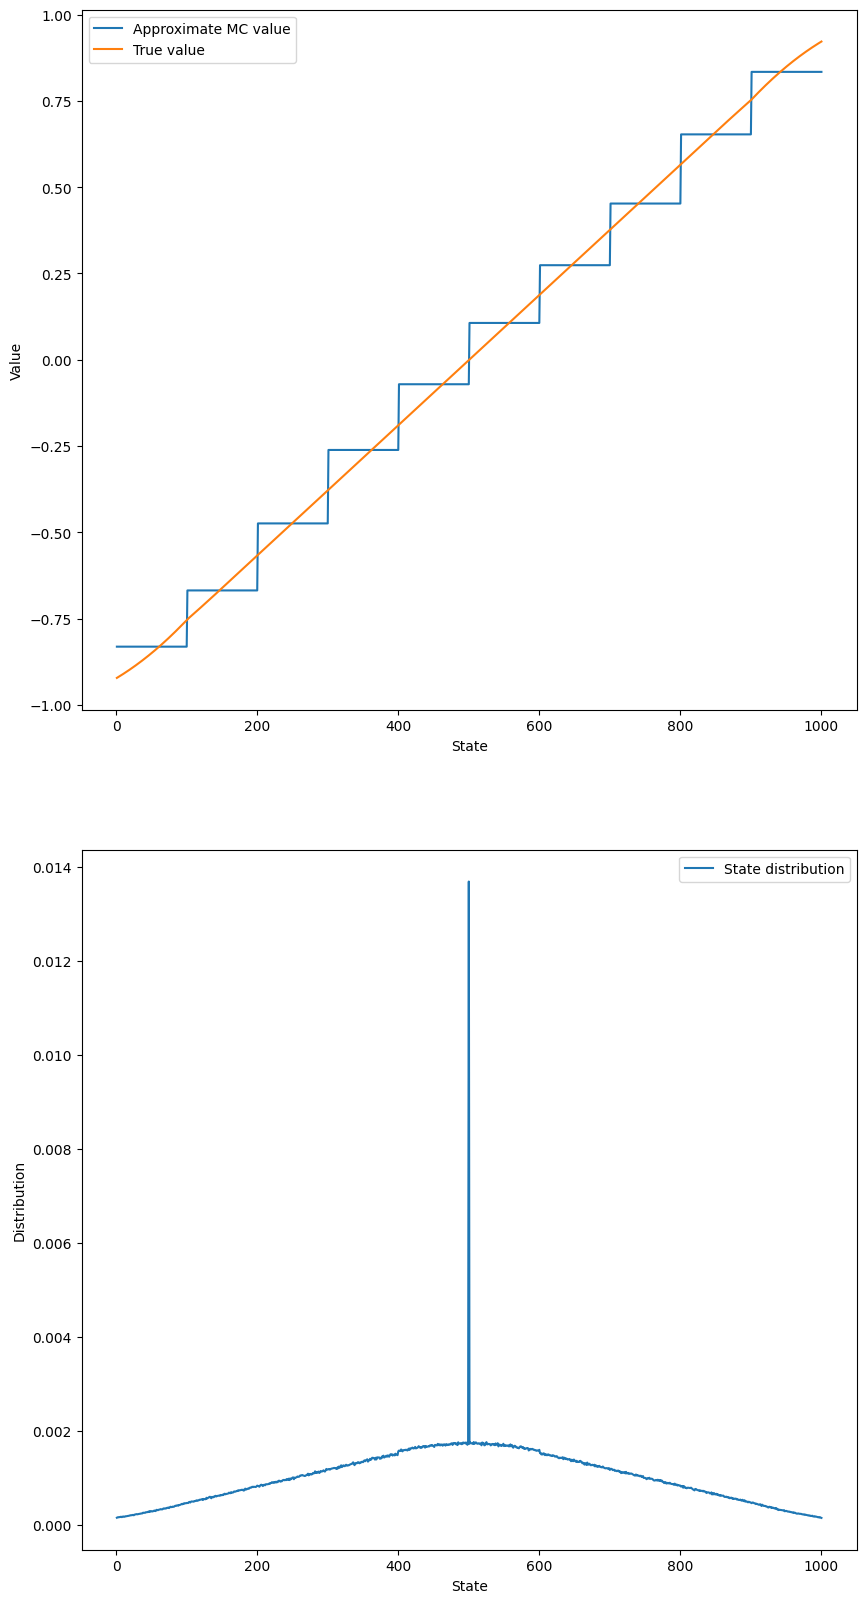

In [10]:
episodes = int(1e5)
alpha = 5e-5

# we have 10 aggregations in this example, each has 100 states
value_function = ValueFunction(10)

distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    gradient_monte_carlo(value_function, alpha, distribution)
    
distribution /= np.sum(distribution)
state_values = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
plt.plot(STATES, state_values, label='Approximate MC value')
plt.plot(STATES, true_value[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(STATES, distribution[1: -1], label='State distribution')
plt.xlabel('State')
plt.ylabel('Distribution')
plt.legend()
plt.show()

### TD Learning with state aggregation feature

100%|█████████████████████████| 100000/100000 [00:22<00:00, 4537.40it/s]


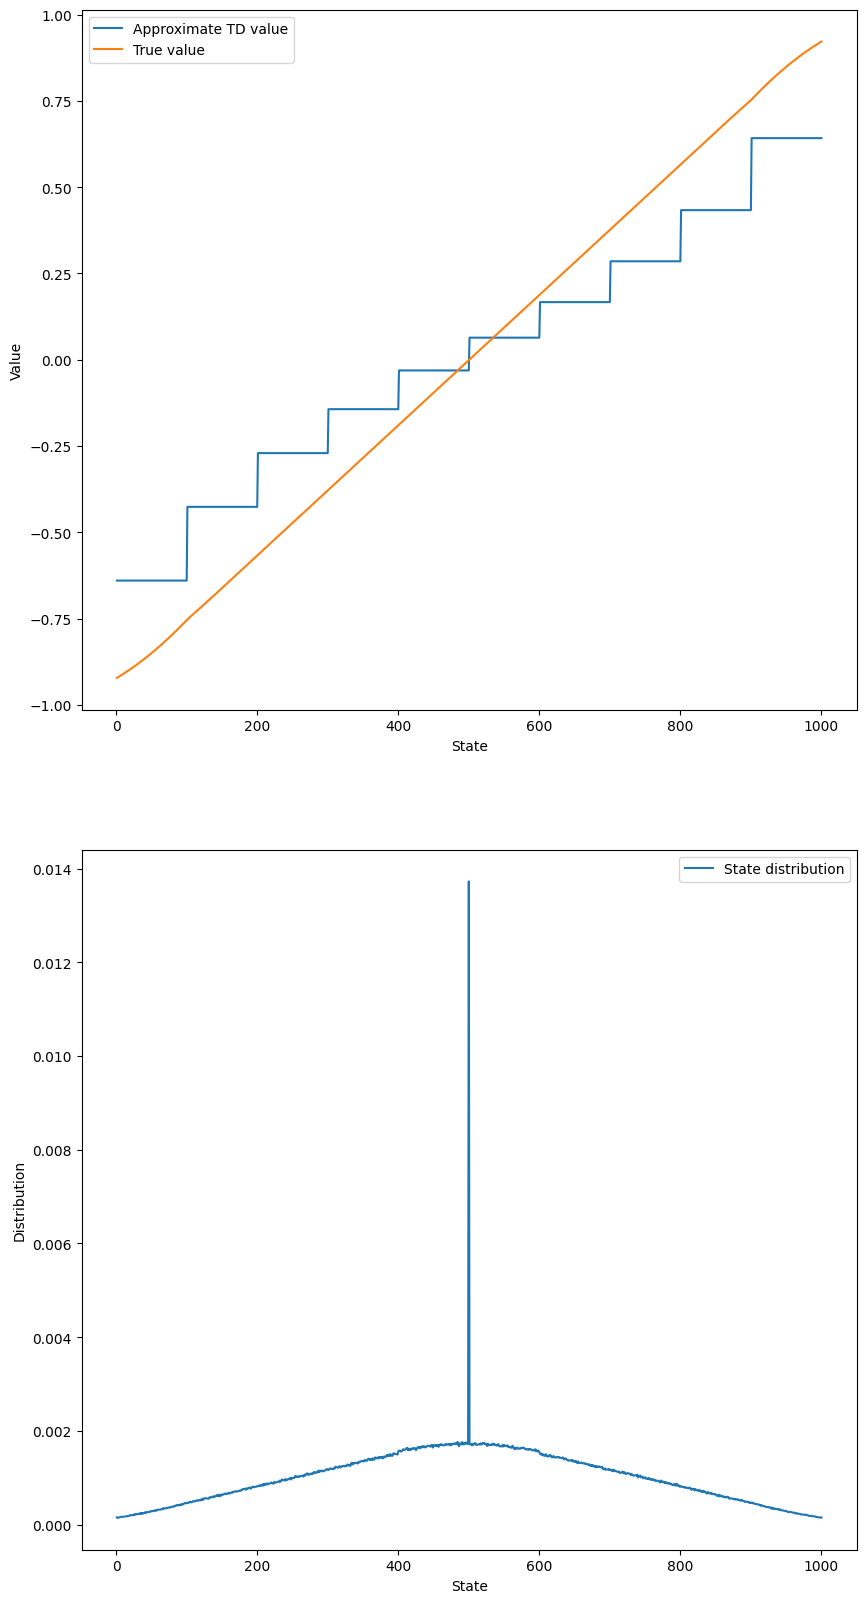

In [11]:
episodes = int(1e5)
alpha = 5e-5

# we have 10 aggregations in this example, each has 100 states
value_function = ValueFunction(10)

distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    semi_gradient_td_0(value_function, alpha, distribution)
    
distribution /= np.sum(distribution)
state_values = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
plt.plot(STATES, state_values, label='Approximate TD value')
plt.plot(STATES, true_value[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(STATES, distribution[1: -1], label='State distribution')
plt.xlabel('State')
plt.ylabel('Distribution')
plt.legend()
plt.show()

### MC learning with polynomial feature (affine function)

100%|█████████████████████████| 500000/500000 [04:20<00:00, 1918.88it/s]


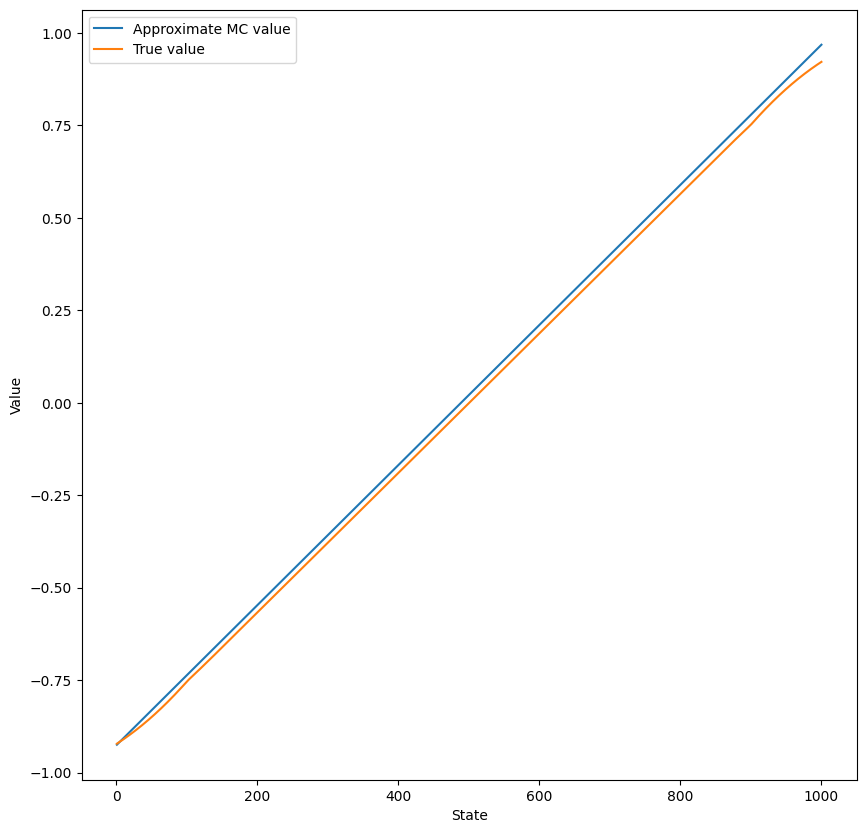

In [12]:
episodes = int(5e5)
alpha = 2e-5

# polynomial of order 1
value_function = BasesValueFunction(1, POLYNOMIAL_BASES)

distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    gradient_monte_carlo(value_function, alpha, distribution)
    
distribution /= np.sum(distribution)
state_values = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 10))

plt.plot(STATES, state_values, label='Approximate MC value')
plt.plot(STATES, true_value[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()

### TD learning with polynomial feature (affine function)

100%|█████████████████████████| 500000/500000 [04:06<00:00, 2026.79it/s]


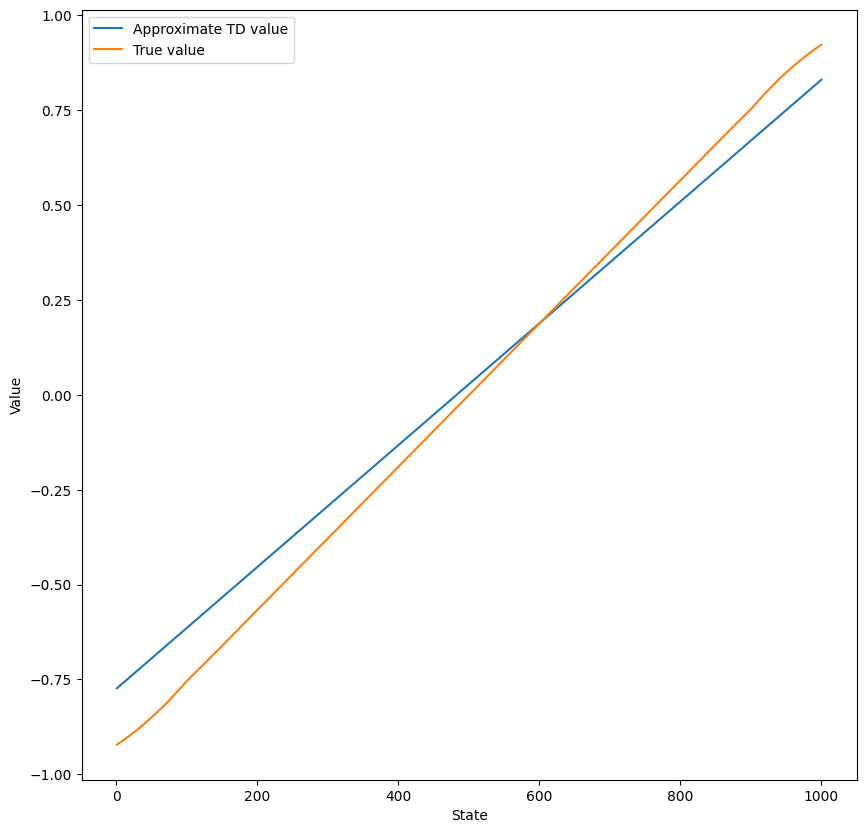

In [13]:
episodes = int(5e5)
alpha = 2e-5

# polynomial of order 1
value_function = BasesValueFunction(1, POLYNOMIAL_BASES)

distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    semi_gradient_td_0(value_function, alpha, distribution)
    
distribution /= np.sum(distribution)
state_values = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 10))

plt.plot(STATES, state_values, label='Approximate TD value')
plt.plot(STATES, true_value[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
GAMMA = 0.5
true_value = compute_true_value()
episodes = int(5e5)
alpha = 2e-5

# polynomial of order 1
value_function = BasesValueFunction(1, POLYNOMIAL_BASES)

distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    semi_gradient_td_0(value_function, alpha, distribution)
    
distribution /= np.sum(distribution)
state_values = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 10))

plt.plot(STATES, state_values, label='Approximate TD value')
plt.plot(STATES, true_value[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()

The remaining error is: 61.134
The remaining error is: 13.349
The remaining error is: 3.501
The remaining error is: 1.028
The remaining error is: 0.319
The remaining error is: 0.102
The remaining error is: 0.033
The remaining error is: 0.011
The remaining error is: 0.004


  3%|▋                         | 14381/500000 [00:07<03:50, 2110.42it/s]

In [ ]:
episodes = int(1e6)
alpha = 1e-4

# polynomial of order 5
value_function = BasesValueFunction(5, POLYNOMIAL_BASES)

distribution = np.zeros(N_STATES + 2)
for ep in tqdm(range(episodes)):
    semi_gradient_td_0(value_function, alpha, distribution)
    
distribution /= np.sum(distribution)
state_values = [value_function.value(i) for i in STATES]

plt.figure(figsize=(10, 10))

plt.plot(STATES, state_values, label='Approximate TD value')
plt.plot(STATES, true_value[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.show()